# Keypoint Classification for Hand Gesture Recognition

https://github.com/kinivi/tello-gesture-control#Gesture-control

https://github.com/Kazuhito00/hand-gesture-recognition-using-mediapipe/tree/main

## Import Necessary Dependacies

In [93]:
import numpy as np
import pandas as pd

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import os 

import matplotlib.pyplot as plt
import seaborn as sns


## Paths

In [94]:
keypoint_dataset = 'data/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

## Load the Training Data

In [95]:
X_dataset = np.loadtxt(keypoint_dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(keypoint_dataset, delimiter=',', dtype='int32', usecols=(0))

## Splitting the data

In [96]:
# 75% 25% split
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=34)

(array([0, 1]), array([1522, 1572], dtype=int64))


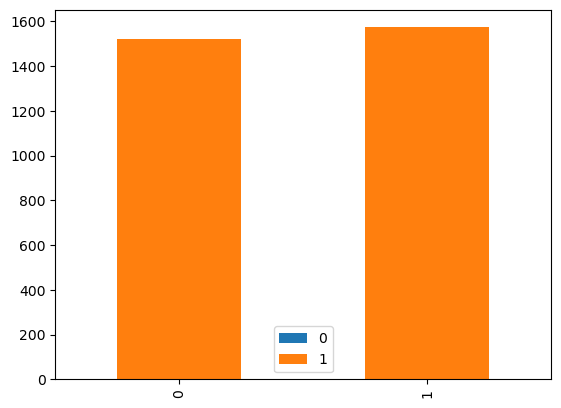

In [97]:
# Classes count
counts = np.unique(y_dataset, return_counts=True)
df = pd.DataFrame(counts)
df.T.plot(kind="bar", stacked=True)
print(counts)

## Building the model

In [98]:
NUM_CLASSES = 2

### Feedforward Neural Network

In [99]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Input((21 * 2, )),
#     tf.keras.layers.Dropout(0.0),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dropout(0.0),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dropout(0.0),
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
# ])

In [100]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [101]:
model.summary() 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_10 (Dropout)        (None, 42)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                1376      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                1056      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 2)                

In [102]:
# Model Checkpoints
# This callback will save the weights of the model every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
    
# Early Stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

In [103]:
# Model Compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Training the model

In [104]:
# save model to plot a curve of accuracy and loss after training
history = model.fit(
    X_train,
    y_train,
    epochs=550,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/550


15/19 [======================>.......] - ETA: 0s - loss: 0.7069 - accuracy: 0.5167 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
19/19 [==============================] - 2s 31ms/step - loss: 0.7022 - accuracy: 0.5203 - val_loss: 0.6613 - val_accuracy: 0.6253
Epoch 2/550
16/19 [========================>.....] - ETA: 0s - loss: 0.6716 - accuracy: 0.5977
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
19/19 [==============================] - 0s 9ms/step - loss: 0.6700 - accuracy: 0.5957 - val_loss: 0.6457 - val_accuracy: 0.6615
Epoch 3/550
17/19 [=========================>....] - ETA: 0s - loss: 0.6536 - accuracy: 0.6163
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
19/19 [==============================] - 0s 9ms/step - loss: 0.6539 - accuracy: 0.6129 - val_loss: 0.6148 - val_accuracy: 0.7739
Epoch 4/550
17/19 [=========================>....] - ETA: 0s - loss: 0.6298 - accuracy: 0.6512
Epoch 4: saving

In [105]:
# Save model for evaluation.
model.save(model_save_path, include_optimizer=False)

## Model Evaluation

### Confusion Matrix

25/25 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       372
           1       1.00      1.00      1.00       402

    accuracy                           1.00       774
   macro avg       1.00      1.00      1.00       774
weighted avg       1.00      1.00      1.00       774

[[372   0]
 [  1 401]]


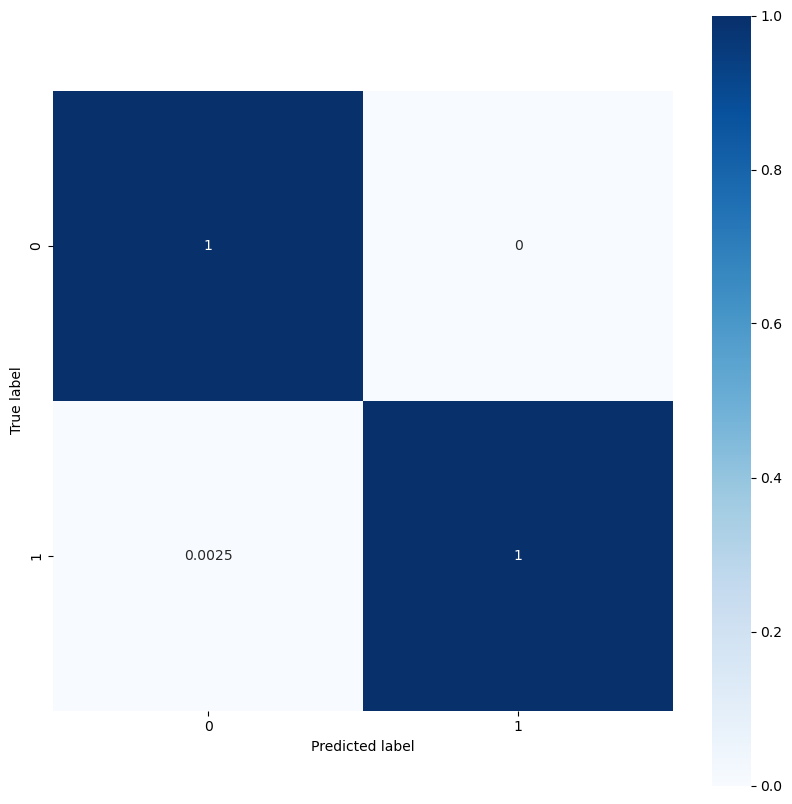

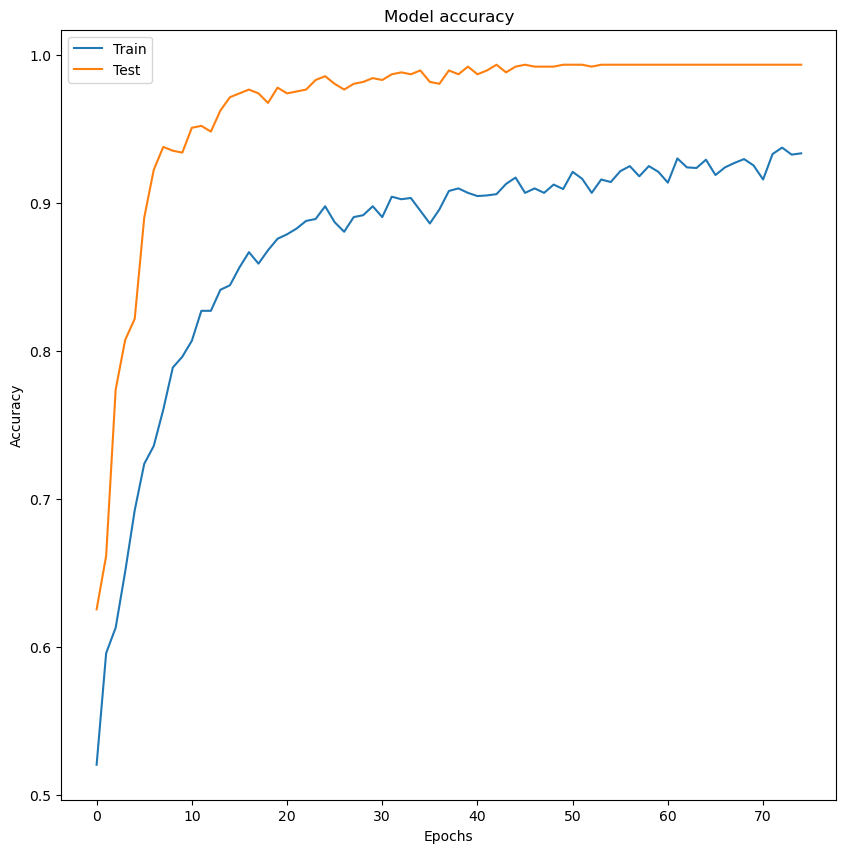

In [106]:
y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, square=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# The model still achieves exceptional results with all metrics reaching 1.00. Reviewing the model in production will provide a 

## TF-Lite Deployment

#### Save the model (inference only)

In [107]:
model.save(model_save_path, include_optimizer=False)

#### Model Quantization

In [108]:
# Model Quantization & Conversion to TFLite 
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Model Quantized. Save the model.
open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\calgr\AppData\Local\Temp\tmp52p38kte\assets


INFO:tensorflow:Assets written to: C:\Users\calgr\AppData\Local\Temp\tmp52p38kte\assets


7576

### Inference Test

In [109]:
# Convert the model to tflite format for inferencing
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [110]:
# Input, Output Tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [111]:
# Set the sample that to be used in inferencing
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [112]:
import time

start_time = time.time()
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
end_time = time.time()
inference_time = end_time - start_time
print("Inference Time: {:.5f} seconds".format(inference_time))


Inference Time: 0.00000 seconds


In [113]:
class_labels = ['Open', 'Close']  # Class labels

predicted_class_index = np.argmax(np.squeeze(tflite_results))
predicted_class_label = class_labels[predicted_class_index]
confidence = tflite_results[0][predicted_class_index]

print("Predicted Class: {} (Confidence: {:.2f}%)".format(predicted_class_label, confidence * 100))


Predicted Class: Close (Confidence: 95.73%)


## Save The Model

In [114]:
# Save the model after inference
with open(tflite_save_path, 'wb') as f:
    tflite_model = tf.lite.TFLiteConverter.from_keras_model(model).convert()
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\calgr\AppData\Local\Temp\tmpkib4_dc4\assets


INFO:tensorflow:Assets written to: C:\Users\calgr\AppData\Local\Temp\tmpkib4_dc4\assets
